In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


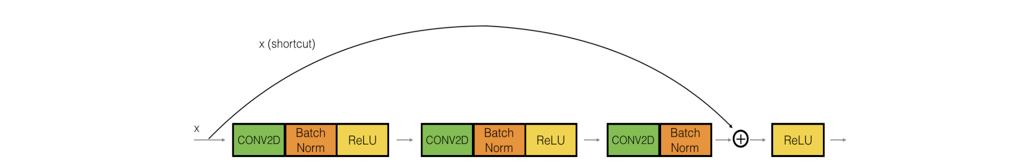

In [2]:
# 标准的残差块

def identity_block(X, f, filters, stage, block):
    """
    根据上图定义的标准残差块（即X与后面的维度相同）
    
    Arguments:
    X -- 输入 -- shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, 指定主路径的中间CONV窗口的形状
    filters -- python列表, 定义主路径的CONV层中的过滤器数量
    stage -- integer, 用于命名图层，具体取决于它们在网络中的位置

    block -- string 用于命名图层，具体取决于它们在网络中的位置
    
    Returns:
    X -- 输出 -- shape (n_H, n_W, n_C)
    """
    
    # 定义名称
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # 定义过滤器
    F1, F2, F3 = filters
    
    # 暂存输入变量供后面“跳跃连接”使用
    X_shortcut = X
    
    # 第一层
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # 第二层
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # 第三层
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # 连接层
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    
    return X

In [3]:
#test
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.19716817 -0.          1.3561227   2.1713073  -0.          1.3324987 ]


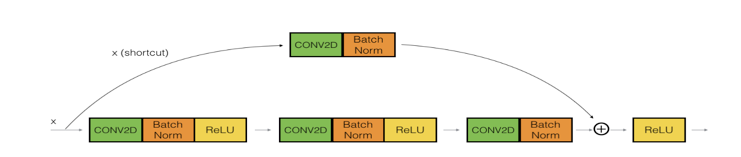

In [4]:
# 带卷积层的残差块

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    根据上图定义的残差块
        
    Arguments:
    X -- 输入 -- shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, 指定主路径的中间CONV窗口的形状
    filters -- python列表, 定义主路径的CONV层中的过滤器数量
    stage -- integer, 用于命名图层，具体取决于它们在网络中的位置

    block -- string 用于命名图层，具体取决于它们在网络中的位置
    s -- Integer, 定义步长
    
    Returns:
    X -- 输出 -- shape (n_H, n_W, n_C)
    """
    
    # 命名
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # 过滤器
    F1, F2, F3 = filters
    
    # 暂存输入变量供后面“跳跃连接”使用
    X_shortcut = X


    # 第一层
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # 第二层
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # 第三层
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### 跳跃连接路径 #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # 跳跃连接
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###
    
    return X

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.09018461  1.2348979   0.46822017  0.03671762 -0.          0.65516603]


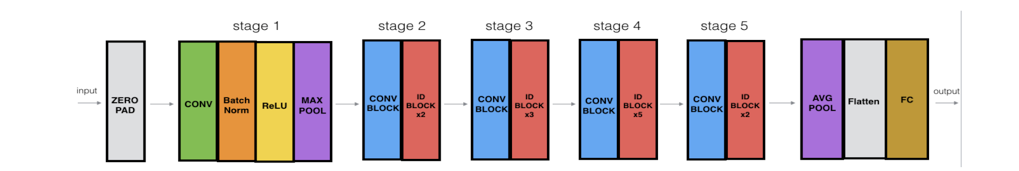

In [6]:
# ResNet50网络

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    根据上图的ResNet50网络图定义:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- 数据集图像的维度
    classes -- integer,分类数

    Returns:
    model -- Keras的model实例
    """
    
    # 定义输入
    X_input = Input(input_shape)

    
    # 0填充
    X = ZeroPadding2D((3, 3))(X_input)
    
    # 第一阶段
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 第二阶段
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    # 第三阶段
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # 第四阶段
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # 第五阶段
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # 均值池化层
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    # 输出层
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [12]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 40s 37ms/step - loss: 1.0228 - acc: 0.7074
Epoch 2/2
1080/1080 [==============================] - 40s 37ms/step - loss: 1.0569 - acc: 0.6972


In [13]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 5s 40ms/step
Loss = 13.43174597422282
Test Accuracy = 0.16666666716337203
